In [1]:
# === Point-Fraction Silhouettes from 3D Points (2 states) ===
# Inputs: two CSVs with ['middle_x','middle_y','middle_z']
# Outputs (in out_dir):
#    - proj_XY.png, proj_YZ.png, proj_XZ.png
#    - overlay_[PLANE]_pXX_pointfrac.png          (XX in e.g. 100,95,90,80,60,50)
#    - metrics_pointfrac.csv  (variant='point_fraction', plus IoU/meanNN/Hausdorff)
#    - meta_pointfrac.json
#
# Notes:
#    - frac_levels are **point fractions** (1.0 == 100% of points)
#    - We rank points by KDE (local crowding), keep the top ceil(frac*N) points,
#      rasterize them, clean the mask, then extract the main contour.
#    - Grid bounds/scale match across A/B via a shared 3D bbox (like HDR pipeline).


import os, json, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional

from scipy.ndimage import binary_closing, binary_opening, label, binary_fill_holes
from scipy.spatial import cKDTree
from skimage.measure import find_contours
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist

np.set_printoptions(suppress=True)

# Config with default values
# pipeline will use these values unless other values are provided in the main function
@dataclass
class CfgPF:
    grid_base:   int   = 160
    pad_frac:    float = 0.05
    frac_levels: Tuple[float, ...] = (1.00, 0.95, 0.90, 0.80, 0.60, 0.50)
    disk_px:     int   = 2
    bandwidth:   Optional[float] = None
    trim_q:      float = 0.10
    icp_iters:   int   = 30
    sample_icp:  int   = 50000
    out_dir:     str   = "out_point_fraction_2state"

# IO
def load_points(csv: str) -> np.ndarray:
    df = pd.read_csv(csv)
    P = df[["middle_x","middle_y","middle_z"]].dropna().values.astype(np.float32)
    if len(P) < 50:
        raise ValueError(f"Too few points in {csv}")
    return P

# Alignment
def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]] # sort eigenvectors by descending eigenvalues
    if np.linalg.det(V) < 0:
        V[:, -1] *= -1 # enforce right-handedness
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1); dAB,_ = tb.query(A_pts, k=1) # distance from each B to nearest A and vice versa
    rmse = float(np.sqrt((np.concatenate([dBA, dAB])**2).mean())) 
    return rmse

# Find the best PCA-based alignment (rotation matrix) of B onto A
# by testing all axis permutations & sign flips, keeping the one with lowest RMSE.
def best_pca_prealign(B_pts, A_pts):
    # get PCA axes
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1,-1], repeat=3))
    # identity matrix
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            # Orthogonal Procrustes Problem
            R = Va @ (P @ S) @ Vb.T
            rmse = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R

# Kabsch rigid alignment from point set Q-->P (compute rotation + translation).
# Note: this implementation returns a transform used later as Q @ R.T + t.
# See https://en.wikipedia.org/wiki/Kabsch_algorithm
# given two sets of paired points P and Q
# Kabsch finds the best rotation R and translation t that makes them overlap as closely as possible
# it does without scaling so distances and shapes stay the same
def kabsch(P, Q):
    # center both sets of points at the origin
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    # compute covariance matrix
    H = Q0.T @ P0
    # SVD = Singular Value Decomposition
    U, S, Vt = np.linalg.svd(H)
    # compute rotation
    R = Vt.T @ U.T
    # ensure a right-handed coordinate system (no reflection)
    if np.linalg.det(R) < 0:
        # flip the last singular vector
        Vt[-1,:] *= -1; R = Vt.T @ U.T
    # compute translation
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    # random number generator
    rs = np.random.default_rng(seed)
    # if sample <= len(pts), use all points
    # else randomly sample without repeat (each points can only be chosen once)
    A = A_pts if len(A_pts)<=sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts)<=sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    
    # identity matrix for rotation, zero vector for translation
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        # Apply the current transform
        Bx = B @ R.T + t
        # Find nearest neighbors
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        # Discard a fraction of worst matches (trim outliers)
        if 0.0 < trim_q < 0.5:
            # keep only the best (1-trim_q) fraction of matches
            thr = np.quantile(d, 1 - trim_q)
            # build a mask of which matches to keep (True/False)
            keep = d <= thr
            # apply the mask
            P, Bx = P[keep], Bx[keep]
        # compute optimal rigid transform on the remaining matches
        # we have P (from A) and Bx (transformed B) pairs
        # we need to find best rotation + shift that brings B onto A
        R_upd, t_upd = kabsch(P, Bx)
        # update the overall transform (order matters!)
        # combine new rotation with previous rotation
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

# Grid 
def make_grid_from_bounds(P: np.ndarray, base=160, pad_frac=0.05):
    # find min and max along each axis (x, y, z)
    # This gives the bounding box of all points P
    mn, mx = P.min(0), P.max(0)
    # Compute the extent = size of the box in each dimension
    ext = mx - mn
    # add padding, expand both min and max by this pad amount
    pad = pad_frac * float(ext.max()); mn -= pad; mx += pad; ext = mx - mn
    # decide how finely to scale the grid
    # base = target size of the longest axis (e.g. 160)
    scale = base / float(ext.max() + 1e-8)
    # compute the number of bins (voxels) along each axis
    # clamp to [32, 512] to avoid too coarse or too fine grids
    dims = np.clip(np.ceil(ext * scale).astype(int), 32, 512)
    # compute the bin edges along each axis
    edges = [np.linspace(mn[i], mx[i], dims[i] + 1, dtype=np.float32) for i in range(3)]
    return edges, dims
    

PLANE_FROM_AXIS = {'z': 'XY', 'y': 'XZ', 'x': 'YZ'}  # drop axis -> plane name
AXPAIR = {'z': (0,1), 'x': (1,2), 'y': (0,2)}      # which coords to project

def save_point_projection_like_screenshot(A, B, i, j, plane, out_dir,
                                          labelA="A", labelB="B"):
    # helper that plots a 2D projection of two point sets A and B and saves it
    all2 = np.vstack([A[:,[i,j]], B[:,[i,j]]])
    # find the min and max along each axis across both sets
    # to get overall rectangle that contains everything
    (xmin,ymin) = all2.min(0); (xmax,ymax) = all2.max(0)
    # compute the range on X and Y axes
    xr, yr = (xmax-xmin), (ymax-ymin); pad = 0.02
    fig, ax = plt.subplots(figsize=(5,4))
    # ligh gray
    ax.set_facecolor("#f0f0f0")
    # plot set A with blue +
    ax.scatter(A[:, i], A[:, j], marker="+", s=8, linewidths=0.6,
               alpha=0.85, c="#1f77b4", label=labelA)
    # plot set B with red x
    ax.scatter(B[:, i], B[:, j], marker="x", s=8, linewidths=0.6,
               alpha=0.75, c="#d62728", label=labelB)
    # set limits with a bit of padding
    ax.set_xlim(xmin - pad*xr, xmax + pad*xr)
    ax.set_ylim(ymin - pad*yr, ymax + pad*yr)
    # equal aspect ratio, no ticks
    ax.set_aspect("equal","box"); ax.set_xticks([]); ax.set_yticks([])
    # title and legend
    ax.set_title(plane); ax.legend(loc="upper left", fontsize=8, frameon=True)
    # save
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"proj_{plane}.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

# Metrics 
# Intersection-over-Union (IoU) for boolean masks
def iou_bool(A: np.ndarray, B: np.ndarray) -> float:
    # if either is None or empty, return NaN
    inter = np.logical_and(A,B).sum()
    union = np.logical_or(A,B).sum()
    return float(inter) / float(union + 1e-9)

# find contour from boolean mask
def contour_from_bool(M: np.ndarray) -> Optional[np.ndarray]:
    if M is None or M.sum() == 0: return None
    # find contours at level 0.5 (between False=0 and True=1)
    cs = find_contours(M.astype(float), level=0.5)
    if not cs: return None
    # return the longest contour
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

# Contour distances (mean nearest neighbor + Hausdorff)
# using cKDTree for fast nearest neighbor search
def contour_distances(CA: Optional[np.ndarray], CB: Optional[np.ndarray]) -> Tuple[float,float]:
    if CA is None or CB is None: return float('nan'), float('nan')
    TA, TB = cKDTree(CA), cKDTree(CB)
    da,_ = TA.query(CB, k=1); db,_ = TB.query(CA, k=1)
    return float((da.mean()+db.mean())/2.0), float(max(da.max(), db.max()))

# ------------------ Point-fraction core ------------------

def project_plane(P: np.ndarray, axis: str) -> np.ndarray:
    d = {'x': [1,2], 'y': [0,2], 'z': [0,1]}[axis]
    return P[:, d]

def kde_scores(points2d: np.ndarray, bandwidth: float) -> np.ndarray:
    """Gaussian KDE score per point (log-density up to constant)."""
    if points2d.shape[0] < 2:
        return np.zeros(points2d.shape[0])
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(points2d)
    return kde.score_samples(points2d)

def auto_bandwidth(points2d: np.ndarray) -> float:
    N = points2d.shape[0]
    if N <= 1:
        return 1.0
    if N > 500:
        idx = np.random.choice(N, size=500, replace=False)
        samp = points2d[idx]
    else:
        samp = points2d
    md = np.median(pdist(samp)) if samp.shape[0] >= 2 else 1.0
    return max(1e-6, md * 0.5)

def rasterize_points(points2d: np.ndarray, xs, ys, disk_px=2) -> np.ndarray:
    """Rasterize points to a binary mask with small disks (radius=disk_px pixels)."""
    ny, nx = len(ys), len(xs)
    img = np.zeros((ny, nx), dtype=bool)
    rr = np.arange(-disk_px, disk_px+1)
    XX, YY = np.meshgrid(rr, rr, indexing='xy')
    disk = (XX**2 + YY**2) <= (disk_px**2)
    dh, dw = disk.shape[0]//2, disk.shape[1]//2
    x_idx = np.clip(np.searchsorted(xs, points2d[:,0]) - 1, 0, nx-1)
    y_idx = np.clip(np.searchsorted(ys, points2d[:,1]) - 1, 0, ny-1)
    for y, x in zip(y_idx, x_idx):
        y0, y1 = max(0, y-dh), min(ny, y+dh+1)
        x0, x1 = max(0, x-dw), min(nx, x+dw+1)
        dy0 = 0 if y0==y-dh else (y-dh - y0)
        dx0 = 0 if x0==x-dw else (x-dw - x0)
        img[y0:y1, x0:x1] |= disk[dy0:dy0+(y1-y0), dx0:dx0+(x1-x0)]
    return img

def biggest_component_mask(mask: np.ndarray) -> np.ndarray:
    """
    Cleans a binary mask by keeping only the largest connected component and filling any holes in it.
    This produces a solid silhouette.
    """
    if mask.sum() == 0:
        return mask

    labeled_mask, num_features = label(mask)
    if num_features == 0:
        return mask

    component_sizes = np.bincount(labeled_mask.ravel())
    if len(component_sizes) <= 1: # Only background found
        return np.zeros_like(mask)

    # Ignore component 0 (background)
    largest_component_label = np.argmax(component_sizes[1:]) + 1
    largest_component = (labeled_mask == largest_component_label)
    solid_mask = binary_fill_holes(largest_component)
    return solid_mask

def point_fraction_mask(points2d: np.ndarray,
                        xs, ys,
                        frac: float,
                        bandwidth: Optional[float],
                        disk_px: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Binary mask enclosing the top ceil(frac*N) points by local density.
    Returns (mask, kept_points2d).
    """
    N = points2d.shape[0]
    k = max(1, int(math.ceil(frac * N)))
    bw = auto_bandwidth(points2d) if bandwidth is None else bandwidth
    scores = kde_scores(points2d, bandwidth=bw)
    order = np.argsort(scores)[::-1]
    keep_idx = order[:k]
    kept = points2d[keep_idx]
    
    mask = rasterize_points(kept, xs, ys, disk_px=disk_px)
    mask = binary_closing(mask, iterations=1)
    mask = binary_opening(mask, iterations=1)
    mask = biggest_component_mask(mask)
    return mask, kept

def point_fraction_contour(points2d: np.ndarray,
                           xs, ys,
                           frac: float,
                           bandwidth: Optional[float],
                           disk_px: int) -> Tuple[Optional[np.ndarray], np.ndarray, np.ndarray]:
    mask, kept = point_fraction_mask(points2d, xs, ys, frac, bandwidth, disk_px)
    C = contour_from_bool(mask)
    return C, mask, kept

def save_overlay_pointfrac_level(background_mask, MA, CA, MB, CB, frac, axis, out_dir, labelA, labelB):
    plane = PLANE_FROM_AXIS[axis]
    fig, ax = plt.subplots(figsize=(5.2, 5.2))
    
    ax.imshow(background_mask, cmap="gray", alpha=0.12)

    if CA is not None:
        ax.plot(CA[:,1], CA[:,0], '-', lw=2.4, color="#1f77b4", alpha=0.95,
                label=f"{labelA} point {int(round(frac*100))}%")
    if CB is not None:
        ax.plot(CB[:,1], CB[:,0], '-', lw=2.4, color="#d62728", alpha=0.95,
                label=f"{labelB} point {int(round(frac*100))}%")
    ax.set_title(f"{plane} — point-fraction {int(round(frac*100))}%")
    ax.set_axis_off(); ax.legend(frameon=False, loc="upper right")
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"overlay_{plane}_p{int(round(frac*100))}_pointfrac.png"),
                dpi=220, bbox_inches="tight")
    plt.close(fig)

# main
def run_point_fraction(csv_A: str, csv_B: str, cfg=CfgPF(),
                       labelA="A", labelB="B"):
    os.makedirs(cfg.out_dir, exist_ok=True)

    # 1) load & center
    A_raw, B_raw = load_points(csv_A), load_points(csv_B)
    # center both at 0, 0, 0
    # mean(0) -> avg each column
    A0, B0 = A_raw - A_raw.mean(0), B_raw - B_raw.mean(0)

    # 2) align B->A (best-PCA, then ICP)
    Rpre = best_pca_prealign(B0, A0)
    # apply pre-align
    B1 = B0 @ Rpre.T
    # refine with robust ICP
    # TODO: may not needed for our case
    # TODO: how to identify the appropiate sample size? 
    Ricp, ticp = icp_rigid_robust(A0, B1, iters=cfg.icp_iters, sample=cfg.sample_icp, trim_q=cfg.trim_q)
    # apply ICP
    A_al, B_al = A0, (B1 @ Ricp.T + ticp)

    #### silhouette analysis ####
    # 3) uniform scale (shared bbox)
    # minimum and maximum XYZ across both sets
    mins = np.vstack([A_al, B_al]).min(0); maxs = np.vstack([A_al, B_al]).max(0)
    # Compute the size of that bounding box along each axis
    s = float((maxs - mins).max())
    # Divide all coordinates by s
    # this scales both point clouds into the same unit cube
    # fits within [-1,1] or [0,1], depending on origin
    A = A_al/s; B = B_al/s

    # 4) shared 3D grid (for consistent 2D edges)
    # creates a global 3D grid that fits both sets of points
    edges3d, _ = make_grid_from_bounds(np.vstack([A, B]), base=cfg.grid_base, pad_frac=cfg.pad_frac)

    # 5) save point projections (XY, YZ, XZ)
    save_point_projection_like_screenshot(A, B, 0, 1, "XY", cfg.out_dir, labelA, labelB)
    save_point_projection_like_screenshot(A, B, 1, 2, "YZ", cfg.out_dir, labelA, labelB)
    save_point_projection_like_screenshot(A, B, 0, 2, "XZ", cfg.out_dir, labelA, labelB)

    metrics_rows = []
    for a in ('x','y','z'):
        plane = PLANE_FROM_AXIS[a]
        i, j = AXPAIR[a]
        ex = edges3d[i]; ey = edges3d[j]
        nx = len(ex) - 1; ny = len(ey) - 1
        xs = np.linspace(ex[0], ex[-1], nx)
        ys = np.linspace(ey[0], ey[-1], ny)

        A2 = A[:, [i, j]]
        B2 = B[:, [i, j]]
        
        # --- ROBUST BACKGROUND GENERATION ---
        # 1. Rasterize all points for each set
        full_mask_A_raw = rasterize_points(A2, xs, ys, disk_px=cfg.disk_px)
        full_mask_B_raw = rasterize_points(B2, xs, ys, disk_px=cfg.disk_px)
        
        # 2. Clean each mask individually using the full, robust process
        clean_mask_A = biggest_component_mask(binary_opening(binary_closing(full_mask_A_raw)))
        clean_mask_B = biggest_component_mask(binary_opening(binary_closing(full_mask_B_raw)))
        
        # 3. Combine them for the final background silhouette
        background_silhouette = np.logical_or(clean_mask_A, clean_mask_B)

        for frac in cfg.frac_levels:
            CA, MA, keptA = point_fraction_contour(A2, xs, ys, frac,
                                                   bandwidth=cfg.bandwidth,
                                                   disk_px=cfg.disk_px)
            CB, MB, keptB = point_fraction_contour(B2, xs, ys, frac,
                                                   bandwidth=cfg.bandwidth,
                                                   disk_px=cfg.disk_px)

            save_overlay_pointfrac_level(background_silhouette, MA, CA, MB, CB, frac, a, cfg.out_dir, labelA, labelB)

            IoU = iou_bool(MA, MB)
            mnn, haus = contour_distances(CA, CB)
            metrics_rows.append(dict(
                plane=plane, level=int(round(frac*100)), variant="point_fraction",
                IoU=IoU, meanNN=mnn, Hausdorff=haus,
                keptA=int(len(keptA)), keptB=int(len(keptB))
            ))

    df = pd.DataFrame(metrics_rows).sort_values(["plane","level"], ascending=[True, False])
    df.to_csv(os.path.join(cfg.out_dir, "metrics_pointfrac.csv"), index=False)

    meta = dict(csv_A=csv_A, csv_B=csv_B,
                label_A=labelA, label_B=labelB,
                cfg=cfg.__dict__,
                note="Per-plane silhouettes enclosing a chosen fraction of points (densest ceil(frac*N) by KDE); PCA+ICP-aligned & shared bbox; masks rasterized and cleaned; main component contoured.")
    with open(os.path.join(cfg.out_dir, "meta_pointfrac.json"), "w") as f:
        json.dump(meta, f, indent=2)

    print(df)
    print(f"[PointFraction] Saved overlays & metrics in: {cfg.out_dir}")

# run
if __name__ == "__main__":
    # Labels for the two conditions (for plots)
    LABEL_A = "12 h — UNTR"
    LABEL_B = "12 h — VACV"
    CSV_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
    CSV_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"

    # Create dummy files for demonstration if they don't exist
    for d in [os.path.dirname(CSV_A), os.path.dirname(CSV_B)]:
        os.makedirs(d, exist_ok=True)
    if not os.path.exists(CSV_A):
        print(f"Creating dummy file for CSV_A: {CSV_A}")
        dummy_data_A = pd.DataFrame(np.random.rand(200, 3) * 100, columns=["middle_x", "middle_y", "middle_z"])
        dummy_data_A.to_csv(CSV_A, index=False)
    if not os.path.exists(CSV_B):
        print(f"Creating dummy file for CSV_B: {CSV_B}")
        dummy_data_B = pd.DataFrame(np.random.rand(200, 3) * 100 + 20, columns=["middle_x", "middle_y", "middle_z"])
        dummy_data_B.to_csv(CSV_B, index=False)

    run_point_fraction(
        CSV_A, CSV_B,
        CfgPF(
            grid_base=160, pad_frac=0.05,
            frac_levels=(1.00, 0.95, 0.90, 0.80, 0.60, 0.50),
            disk_px=2,
            bandwidth=None,
            trim_q=0.10, icp_iters=30, sample_icp=50000,
            out_dir="data/green_monkey/va_testing/out_pointfrac_modified"
        ),
        labelA=LABEL_A, labelB=LABEL_B
    )

   plane  level         variant       IoU    meanNN  Hausdorff  keptA  keptB
12    XY    100  point_fraction  0.722209  4.758943  21.931712   1931   1931
13    XY     95  point_fraction  0.694811  5.234208  21.931712   1835   1835
14    XY     90  point_fraction  0.672449  5.518156  17.804494   1738   1738
15    XY     80  point_fraction  0.667499  5.199260  16.552945   1545   1545
16    XY     60  point_fraction  0.688383  4.544898  16.643317   1159   1159
17    XY     50  point_fraction  0.706352  4.076692  15.231546    966    966
6     XZ    100  point_fraction  0.622609  5.244961  20.024984   1931   1931
7     XZ     95  point_fraction  0.572795  5.944861  22.627417   1835   1835
8     XZ     90  point_fraction  0.534595  6.930256  29.068884   1738   1738
9     XZ     80  point_fraction  0.521628  6.323291  25.942244   1545   1545
10    XZ     60  point_fraction  0.465405  6.616799  26.248809   1159   1159
11    XZ     50  point_fraction  0.429163  6.851306  26.162951    966    966

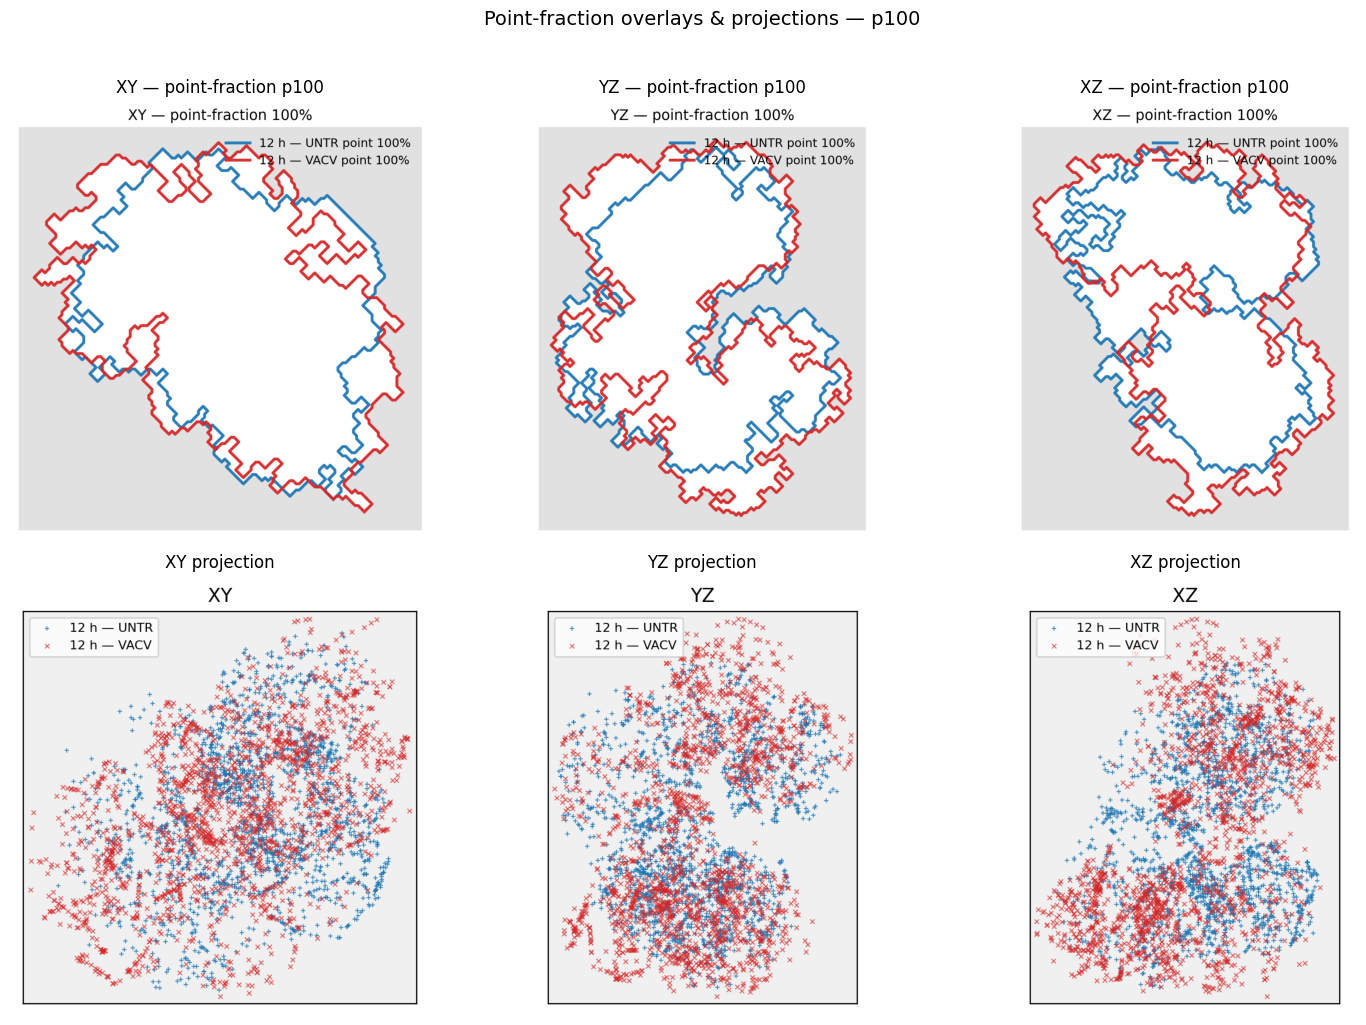

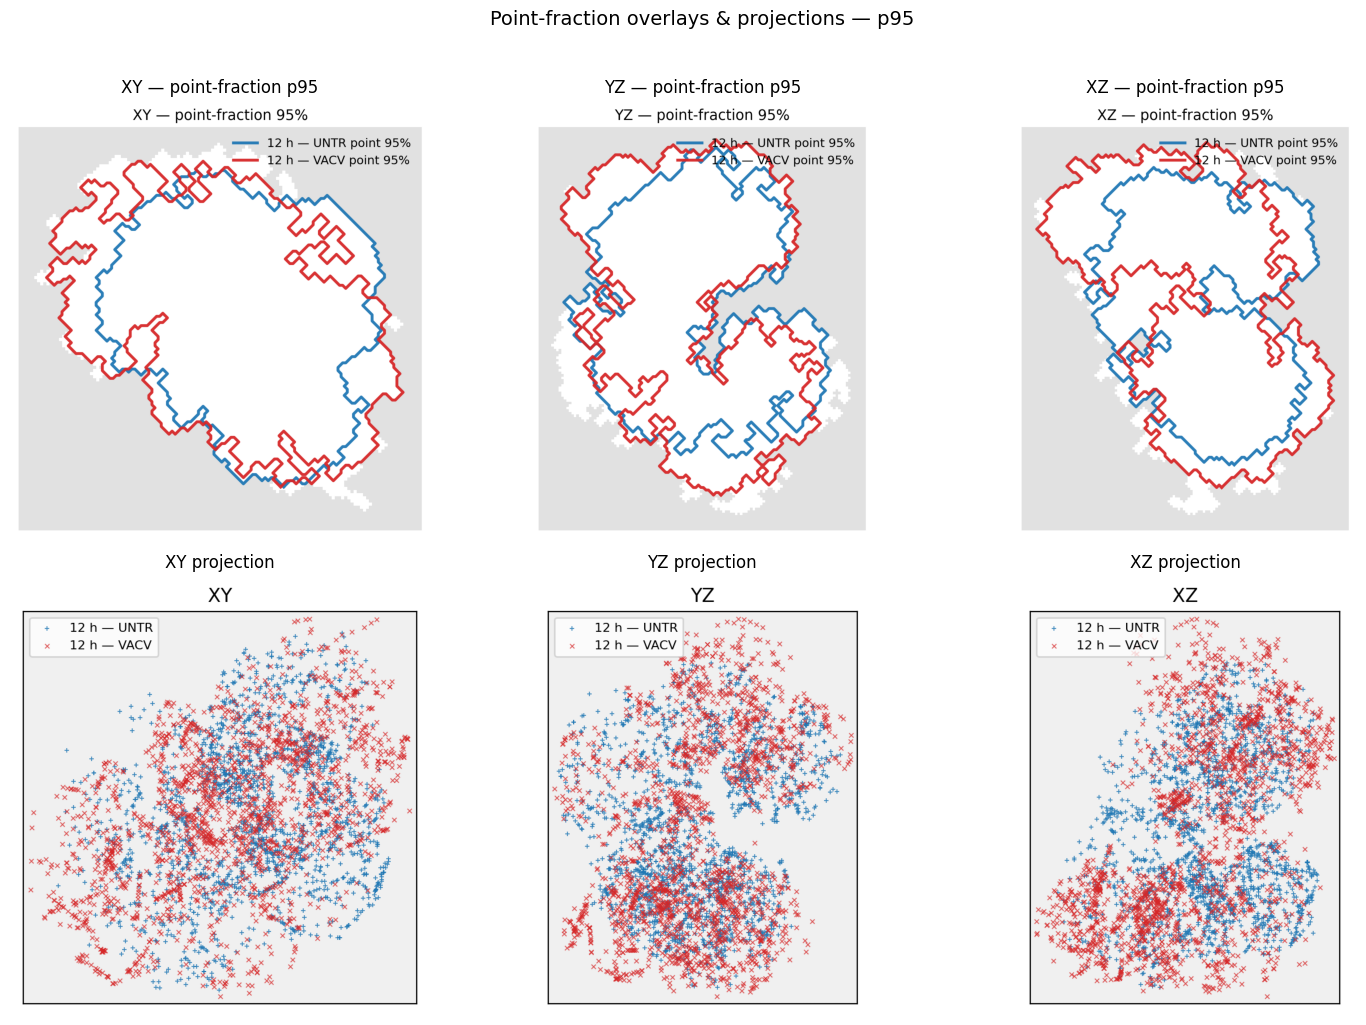

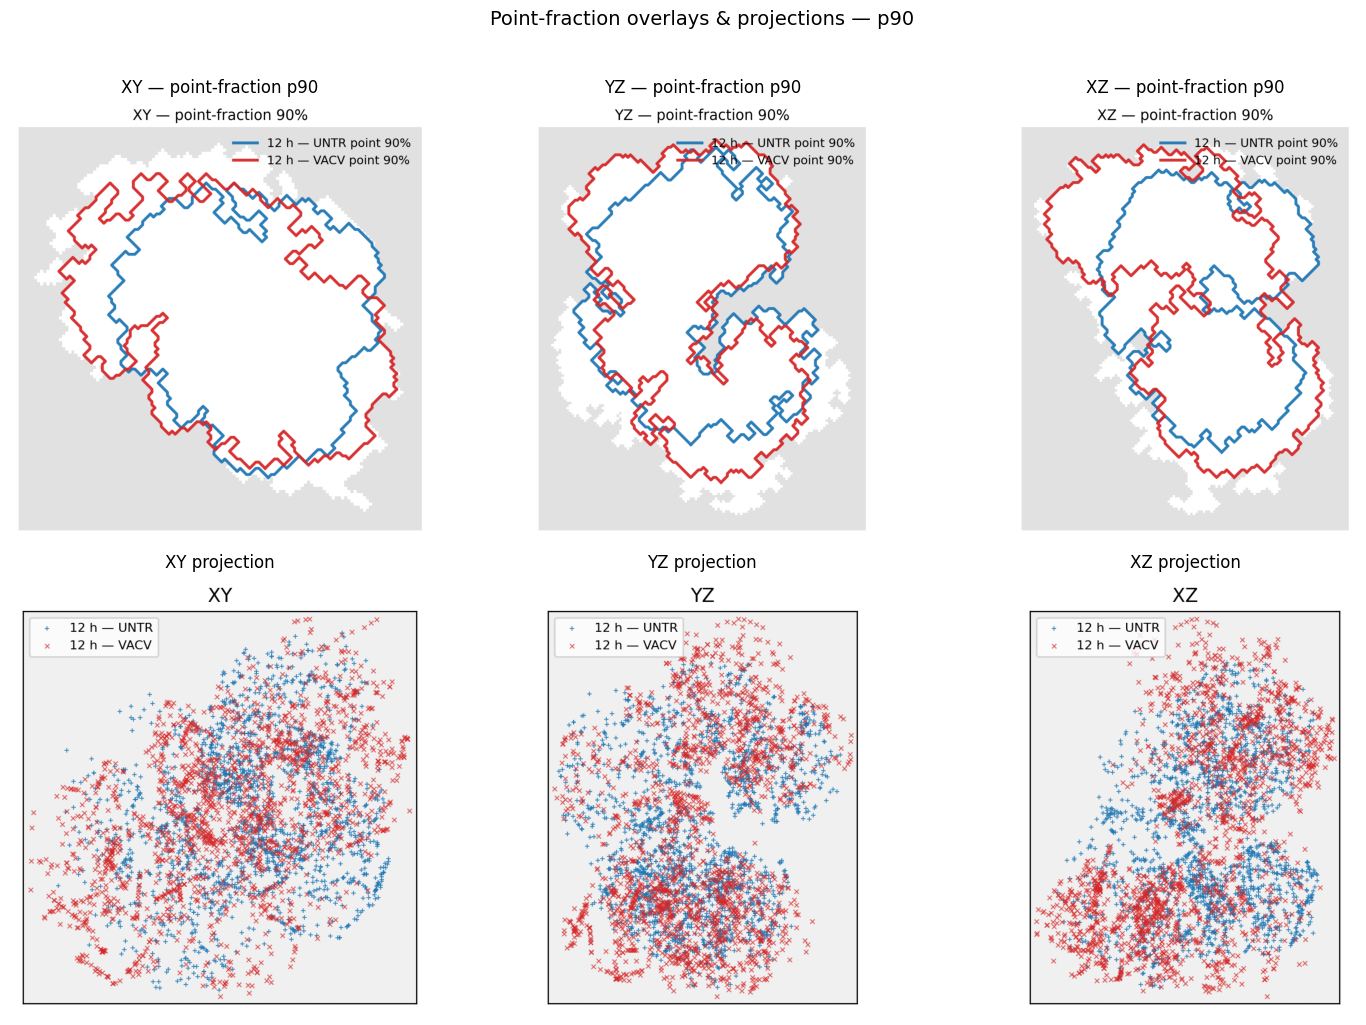

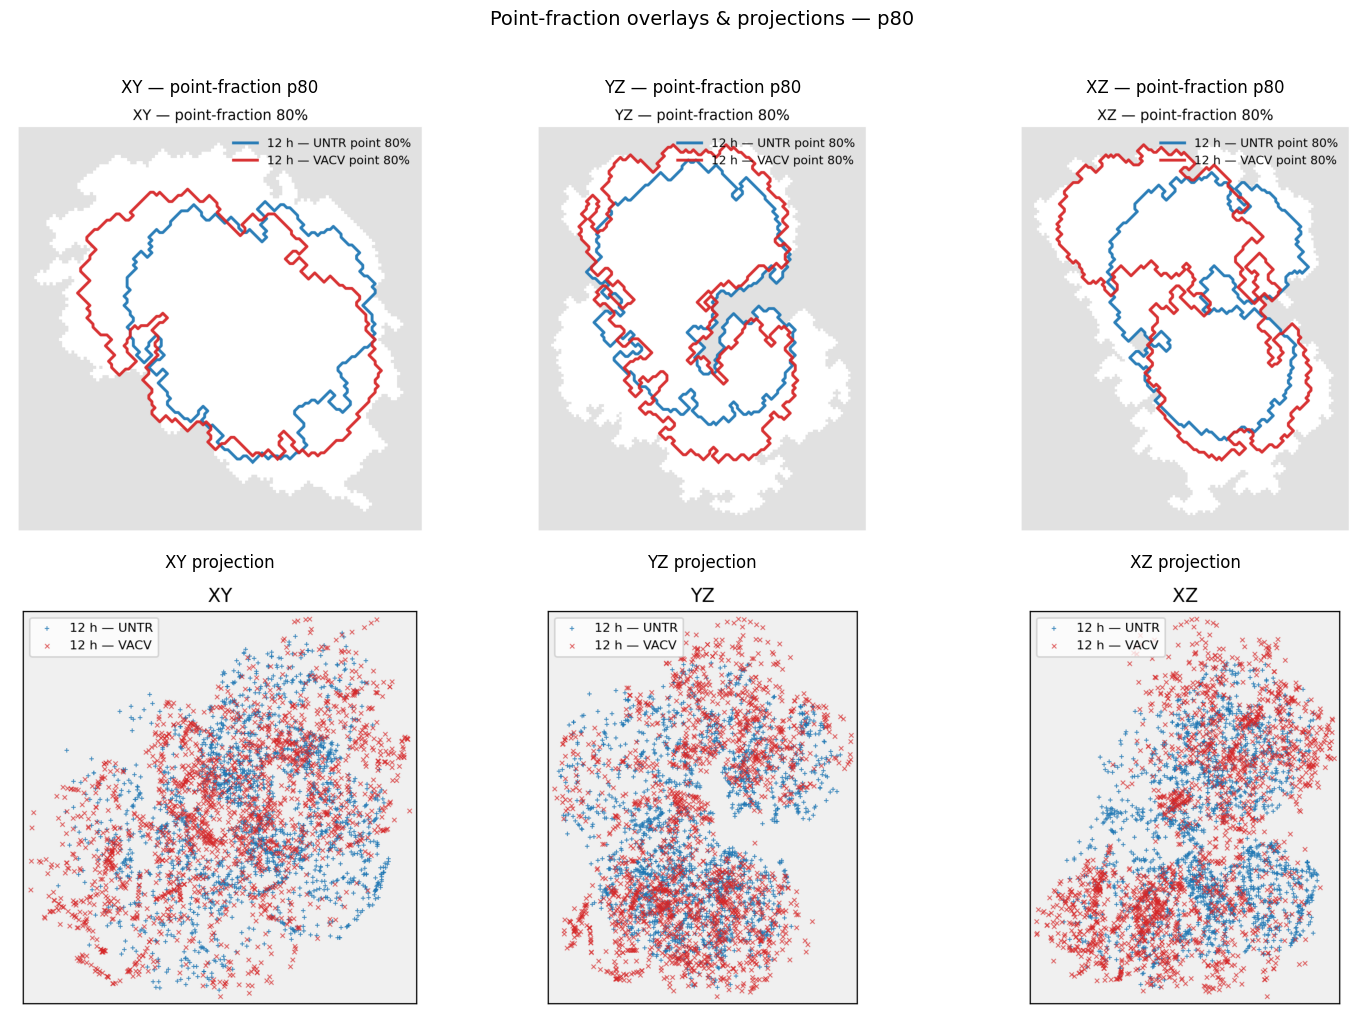

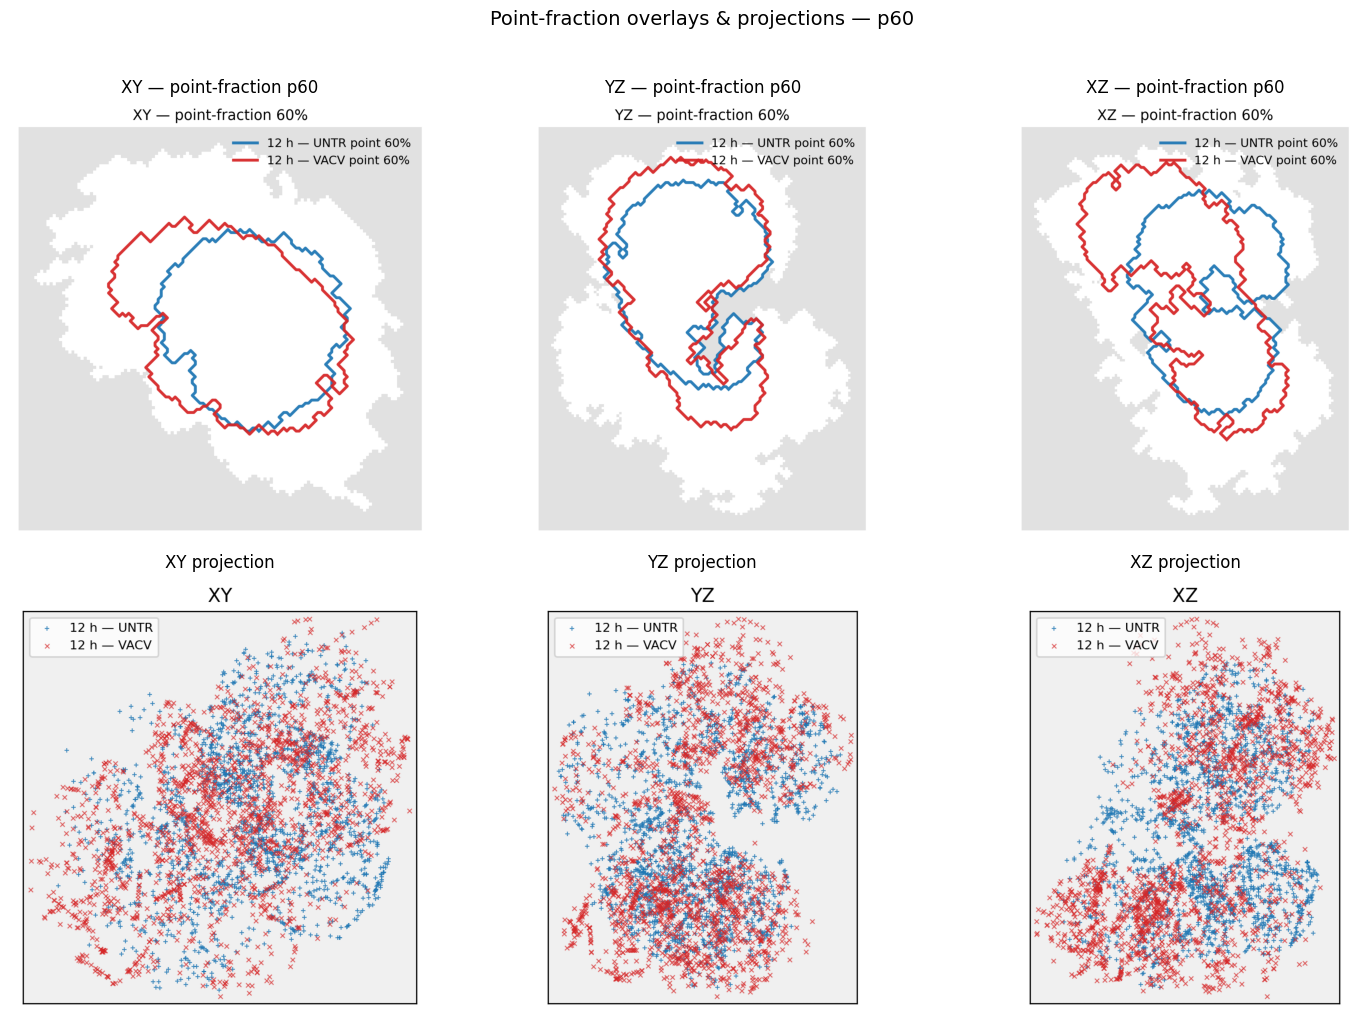

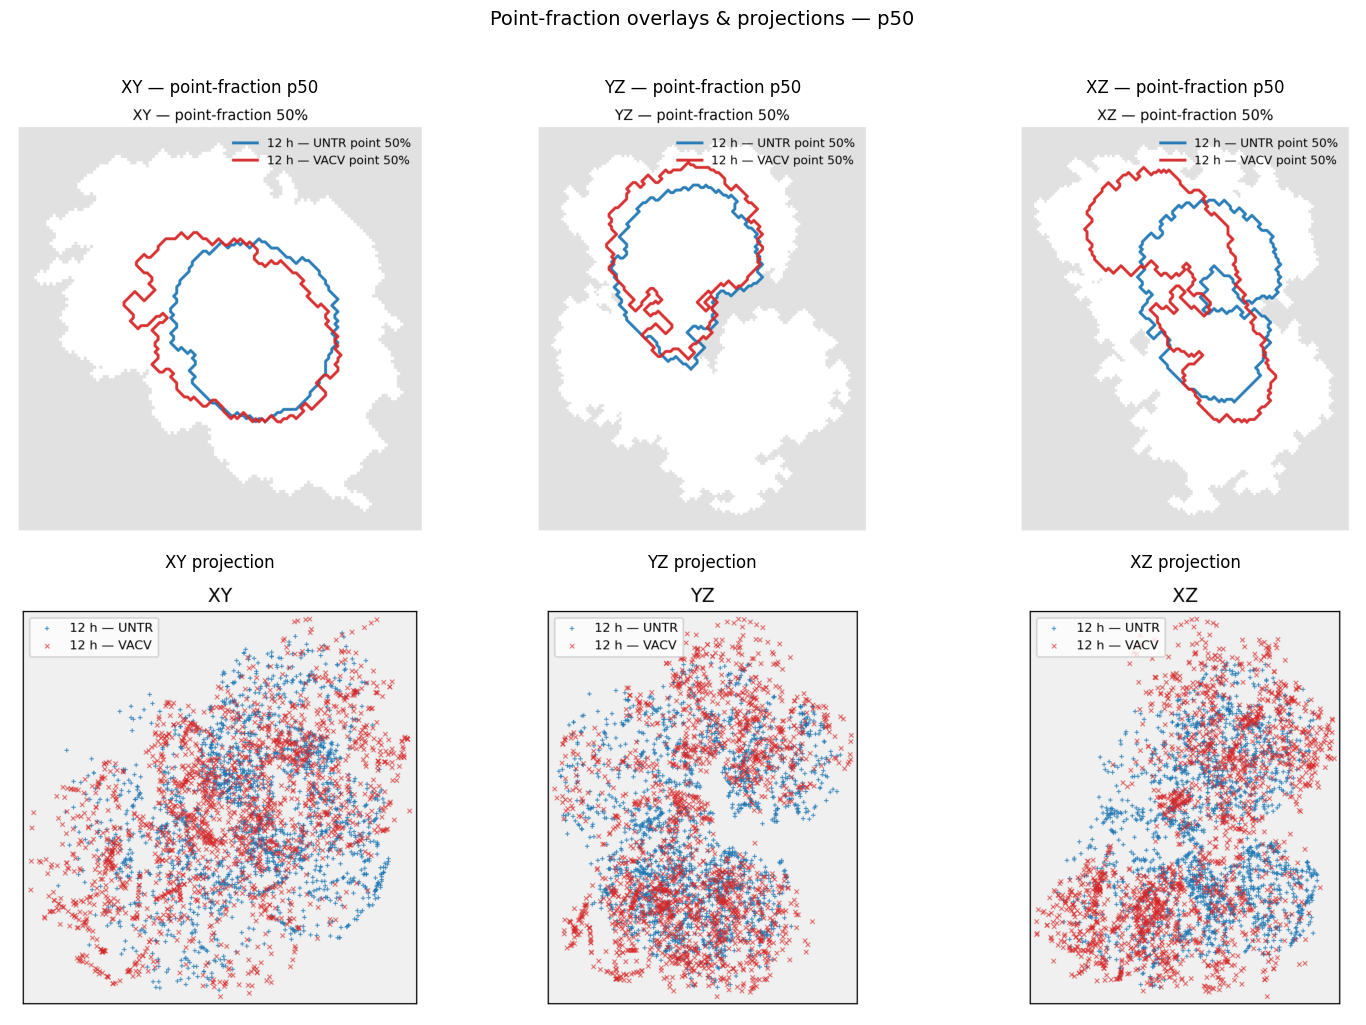

In [2]:
import os, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg

OUT_PF = "data/green_monkey/va_testing/out_pointfrac_modified"  # point-fraction out_dir

def show_pointfrac_and_projections(levels=(1.00, 0.95, 0.90, 0.80, 0.60, 0.50),
                                   planes=("XY","YZ","XZ"),
                                   out_dir=OUT_PF,
                                   save=False,
                                   save_dir=None,
                                   dpi=180):
    """
    For each level in `levels`, show a panel:
      Row 1: overlay_<PLANE>_pXX_pointfrac.png  (per-level point-fraction contour for A vs B)
      Row 2: proj_<PLANE>.png                   (point projection)
    """
    for p in levels:
        p_int = int(round(p*100))
        ptag = f"p{p_int}"

        nrows = 2
        fig, axs = plt.subplots(nrows, len(planes), figsize=(15, 10))

        # handle 1D/2D axes consistently
        if nrows == 1:
            axs = np.array([axs])
        if axs.ndim == 1:
            axs = axs[None, :]

        # --- Row 1: point-fraction overlays ---
        for col, plane in enumerate(planes):
            ax = axs[0, col]
            overlay_path = os.path.join(out_dir, f"overlay_{plane}_{ptag}_pointfrac.png")
            if os.path.exists(overlay_path):
                ax.imshow(mpimg.imread(overlay_path))
                ax.set_title(f"{plane} — point-fraction {ptag}", fontsize=12)
            else:
                ax.text(0.5, 0.5, f"Missing overlay_{plane}_{ptag}_pointfrac.png",
                        ha="center", va="center")
            ax.axis("off")

        # --- Row 2: point projections ---
        for col, plane in enumerate(planes):
            ax = axs[1, col]
            proj_path = os.path.join(out_dir, f"proj_{plane}.png")
            if os.path.exists(proj_path):
                ax.imshow(mpimg.imread(proj_path))
                ax.set_title(f"{plane} projection", fontsize=12)
            else:
                ax.text(0.5, 0.5, f"Missing proj_{plane}.png",
                        ha="center", va="center")
            ax.axis("off")

        plt.suptitle(f"Point-fraction overlays & projections — {ptag}", y=1.02, fontsize=14)
        plt.tight_layout()

        if save:
            os.makedirs(save_dir or out_dir, exist_ok=True)
            out_png = os.path.join(save_dir or out_dir, f"panel_{ptag}_pointfrac.png")
            plt.savefig(out_png, dpi=dpi, bbox_inches="tight")
        plt.show()

# quick view
show_pointfrac_and_projections(
    levels=(1.00, 0.95, 0.90, 0.80, 0.60, 0.50),
    planes=("XY","YZ","XZ"),
    out_dir=OUT_PF,
    save=False
)
